In [1]:
def from_data_x():
    data = pd.read_csv('features.csv',header=None)
    return data.to_numpy()
def from_data_y():
    labels = pd.read_csv('labels.csv',header=None)
    return labels.to_numpy()

In [2]:
"""
    xgboost模型调参、训练、保存、预测
    官网信息辅助理解：
    xgboost官网参数(default) https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
    sklearn评估指标(Metrics) https://scikit-learn.org/stable/modules/model_evaluation.html
"""
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']


In [3]:
# 假设data是包含数据的DataFrame，target是包含标签的Series
X = from_data_x()  # 特征数据
y = from_data_y()  # 标签数据
# print(y.shape)
# y = np.array([0 if i == 1 else 1 for i in y])

# 如果需要查看特征的重要性
# print(xgb_clf.feature_importances_)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def xgboost_parameters():
    """模型调参过程"""
    # 第一步：确定迭代次数 n_estimators
    # 参数的最佳取值：{'n_estimators': 4}
    # 最佳模型得分:0.9180952380952381
    # params = {'n_estimators': [1,2,3,4,5]}

    # 第二步：min_child_weight[default=1],range: [0,∞] 和 max_depth[default=6],range: [0,∞]
    # min_child_weight:如果树分区步骤导致叶节点的实例权重之和小于min_child_weight,那么构建过程将放弃进一步的分区,最小子权重越大,算法就越保守
    # max_depth:树的最大深度,增加该值将使模型更复杂,更可能过度拟合,0表示深度没有限制
    # 参数的最佳取值：{'max_depth': 11, 'min_child_weight': 1}
    # 最佳模型得分:0.9180952380952381，模型分数未提高
    # params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15], 'min_child_weight': [1, 2, 3, 4, 5, 6]}

    # 第三步:gamma[default=0, alias: min_split_loss],range: [0,∞]
    # gamma:在树的叶子节点上进行进一步分区所需的最小损失下降,gamma越大,算法就越保守
    # 参数的最佳取值：{'gamma': 0.3}
    # 最佳模型得分:0.9247619047619049
    # params = {'gamma': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}

    # 第四步：subsample[default=1],range: (0,1] 和 colsample_bytree[default=1],range: (0,1]
    # subsample:训练实例的子样本比率。将其设置为0.5意味着XGBoost将在种植树木之前随机抽样一半的训练数据。这将防止过度安装。每一次提升迭代中都会进行一次子采样。
    # colsample_bytree:用于列的子采样的参数,用来控制每颗树随机采样的列数的占比。有利于满足多样性要求,避免过拟合
    # 参数的最佳取值：{'colsample_bytree': 1, 'subsample': 1}
    # 最佳模型得分:0.9247619047619049, 无提高即默认值
    # params = {'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]}

    # 第五步：alpha[default=0, alias: reg_alpha], 和 lambda[default=1, alias: reg_lambda]
    # alpha:L1关于权重的正则化项。增加该值将使模型更加保守
    # lambda:关于权重的L2正则化项。增加该值将使模型更加保守
    # 参数的最佳取值：{'reg_alpha': 0.1, 'reg_lambda': 1}
    # 最佳模型得分:0.9380952380952381
    # params = {'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1, 2, 3], 'lambda': [0.05, 0.1, 1, 2, 3, 4]}

    # 第六步：learning_rate[default=0.3, alias: eta],range: [0,1]
    # learning_rate:一般这时候要调小学习率来测试,学习率越小训练速度越慢,模型可靠性越高,但并非越小越好
    # 参数的最佳取值：{'learning_rate': 0.25}
    # 最佳模型得分:0.9380952380952381, 无提高即默认值
    params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2, 0.25, 0.3, 0.4]}

    # 其他参数设置，每次调参将确定的参数加入
    # fine_params = {'n_estimators': 50, 'max_depth': 2, 'min_child_weight': 1, 'gamma': 0.1, 'colsample_bytree': 1,
    #                'subsample': 1, 'reg_alpha': 0.01, 'reg_lambda': 3, 'learning_rate': 0.3}
    fine_params = {'n_estimators': 4,'max_depth': 11, 'min_child_weight': 1,'gamma': 0.3,'colsample_bytree': 1, 'subsample': 1,'reg_alpha': 0.1, 'reg_lambda': 1,'learning_rate':0.25}
    return params, fine_params


In [6]:
def model_adjust_parameters(cv_params, other_params):
    """模型调参"""
    # 模型基本参数
    model = XGBClassifier(**other_params)
    # sklearn提供的调参工具，训练集k折交叉验证
    optimized_param = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1)
    # 模型训练
    optimized_param.fit(X_train, y_train)
    # 对应参数的k折交叉验证平均得分
    means = optimized_param.cv_results_['mean_test_score']
    params = optimized_param.cv_results_['params']
    for mean, param in zip(means, params):
        print("mean_score: %f,  params: %r" % (mean, param))
    # 最佳模型参数
    print('参数的最佳取值：{0}'.format(optimized_param.best_params_))
    # 最佳参数模型得分
    print('最佳模型得分:{0}'.format(optimized_param.best_score_))

    # 模型参数调整得分变化曲线绘制
    parameters_score = pd.DataFrame(params, means)
    parameters_score['means_score'] = parameters_score.index
    parameters_score = parameters_score.reset_index(drop=True)
    parameters_score.to_excel('parameters_score.xlsx', index=False)
    # 画图
    plt.figure(figsize=(15, 12))
    plt.subplot(2, 1, 1)
    plt.plot(parameters_score.iloc[:, :-1], 'o-')
    plt.legend(parameters_score.columns.to_list()[:-1], loc='upper left')
    plt.title('Parameters_size', loc='left', fontsize='xx-large', fontweight='heavy')
    plt.subplot(2, 1, 2)
    plt.plot(parameters_score.iloc[:, -1], 'r+-')
    plt.legend(parameters_score.columns.to_list()[-1:], loc='upper left')
    plt.title('Score', loc='left', fontsize='xx-large', fontweight='heavy')
    plt.show()



In [7]:
pos = 0
for label in y:
    if label == 1:
        pos+=1
print(1-pos/y.shape[0])


0.8292181069958848


Fitting 5 folds for each of 8 candidates, totalling 40 fits
mean_score: 0.484931,  params: {'learning_rate': 0.01}
mean_score: 0.483437,  params: {'learning_rate': 0.05}
mean_score: 0.488019,  params: {'learning_rate': 0.07}
mean_score: 0.484741,  params: {'learning_rate': 0.1}
mean_score: 0.484615,  params: {'learning_rate': 0.2}
mean_score: 0.490750,  params: {'learning_rate': 0.25}
mean_score: 0.490729,  params: {'learning_rate': 0.3}
mean_score: 0.489776,  params: {'learning_rate': 0.4}
参数的最佳取值：{'learning_rate': 0.25}
最佳模型得分:0.49074982970069225


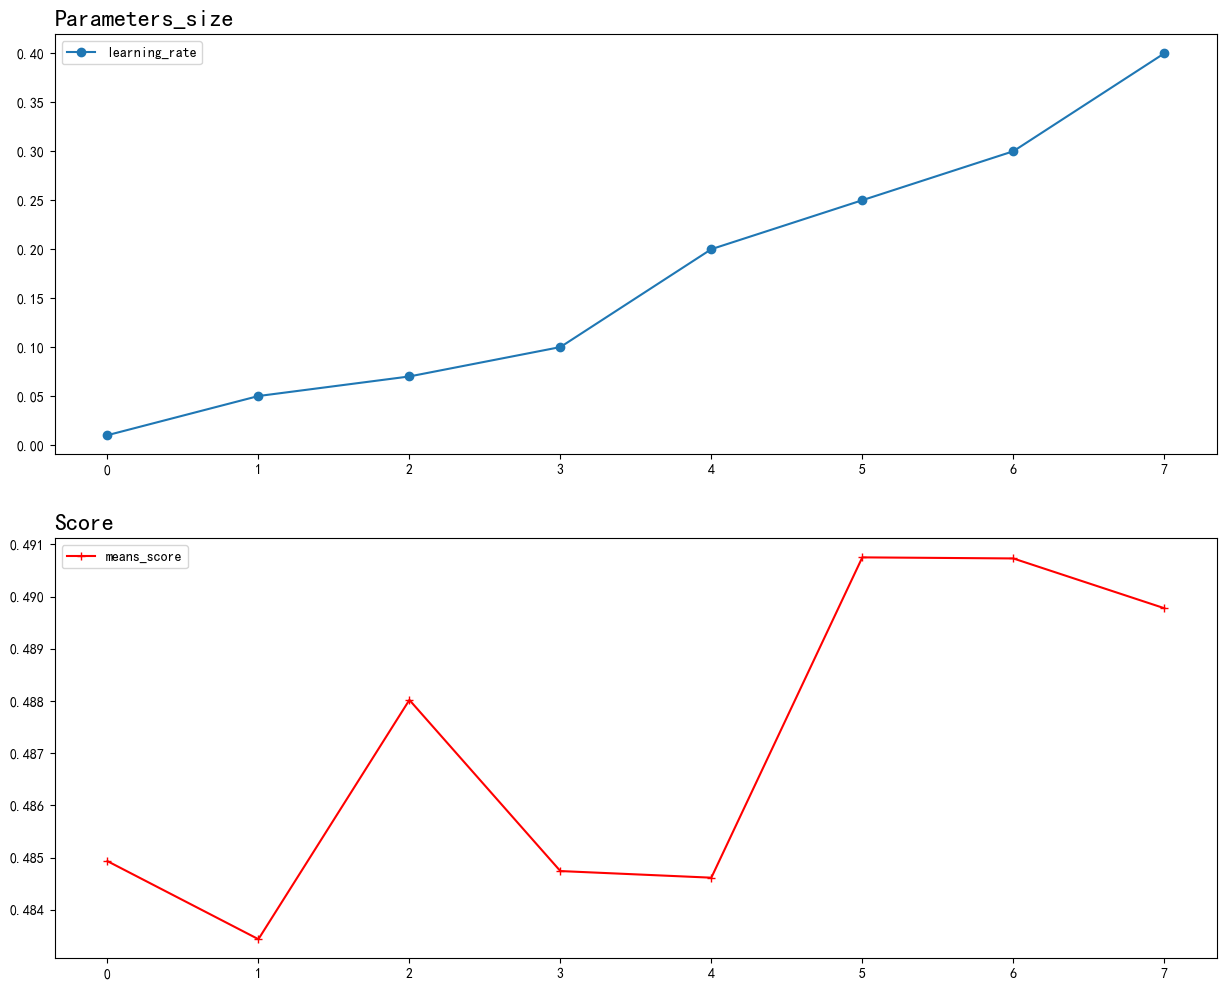

In [8]:

"""
    模型调参
    调参策略：网格搜索、随机搜索、启发式搜索
    补充：此处采用启发式搜索，逐个或逐类参数调整，避免所有参数一起调整导致模型训练复杂度过高
"""
# xgboost参数组合
adj_params, fixed_params = xgboost_parameters()

# 模型调参
model_adjust_parameters(adj_params, fixed_params)


In [9]:
def model_fit():
    """模型训练"""
    # XGBoost训练过程，下面的参数是调试出来的最佳参数组合
    model = XGBClassifier(n_estimators= 4,max_depth= 11, min_child_weight= 1,gamma= 0.3,colsample_bytree= 1,subsample=1,reg_alpha= 0.1, reg_lambda= 1,learning_rate=0.25)
    # model = RandomForestClassifier(n_estimators=200)

    # model = AdaBoostClassifier(random_state=37)
    model.fit(X_train, y_train)

    # 对验证集进行预测——类别
    y_pred = model.predict(X_test)
    y_test_ = y_test
    # print('y_test：', y_test_)
    # print('y_pred：', y_pred)

	# 对验证集进行预测——概率
    y_pred_proba = model.predict_proba(X_test)
    # print(y_pred_proba)
    # 结果类别是1的概率
    y_pred_proba_ = []
    for i in y_pred_proba.tolist():
        exit(0)
        y_pred_proba_.append(i[1])
    # print('y_pred_proba：', y_pred_proba_)

    # 模型对验证集预测结果评分
    metrics_sklearn(y_pred)

    # 模型特征重要性提取、展示和保存
    # feature_importance_selected(model)

    return model

In [10]:
from sklearn.metrics import precision_score,recall_score,roc_auc_score,roc_curve
def metrics_sklearn( y_pred_,y_valid=y_test):
    """模型对验证集和测试集结果的评分"""
    # 准确率
    accuracy = accuracy_score(y_valid, y_pred_)
    print('Accuracy：%.6f%%' % (accuracy * 100))

    # 精准率
    precision = precision_score(y_valid, y_pred_)
    print('Precision：%.6f%%' % (precision * 100))

    # 召回率
    recall = recall_score(y_valid, y_pred_)
    # print(y_valid)
    # print('-----------------------------')
    # print(y_pred_)
    print('Recall：%.6f%%' % (recall * 100))

    # F1值
    f1 = f1_score(y_valid, y_pred_)
    print('F1：%.6f%%' % (f1 * 100))

    # auc曲线下面积
    auc = roc_auc_score(y_valid, y_pred_)
    print('AUC：%.6f%%' % (auc * 100))

    # ks值
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_)
    ks = max(abs(fpr - tpr))
    print('KS：%.6f%%' % (ks * 100))


In [11]:
def feature_importance_selected(clf_model):
    """模型特征重要性提取与保存"""
    # 模型特征重要性打印和保存
    feature_importance = clf_model.get_booster().get_fscore()
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    feature_ipt = pd.DataFrame(feature_importance, columns=['特征名称', '重要性'])
    feature_ipt.to_csv('feature_importance.csv', index=False)
    print('特征重要性:', feature_importance)

    # 模型特征重要性绘图
    plot_importance(clf_model)
    plt.show()


In [12]:
def model_save_type(clf_model):
    # 模型训练完成后做持久化，模型保存为model模式，便于调用预测
    clf_model.save_model('xgboost_classifier_model.model')

    # 模型保存为文本格式，便于分析、优化和提供可解释性
    clf = clf_model.get_booster()
    clf.dump_model('dump.txt')


In [13]:

"""
    模型训练、评分与保存
    结论：训练集k折交叉验证带来的模型评分提升，未必会在测试集上得到提升
"""
# 模型训练
model_xgbclf = model_fit()
# 模型保存：model和txt两种格式
# model_save_type(model_xgbclf)


Accuracy：84.205607%
Precision：0.000000%
Recall：0.000000%
F1：0.000000%
AUC：50.000000%
KS：0.000000%


In [14]:
def model_load(model, x_transform):
    # 模型加载
    clf = xgb.XGBClassifier()
    booster = xgb.Booster()
    booster.load_model(model)
    clf._Booster = booster

    # 数据预测
    y_pred = [round(value) for value in clf.predict(x_transform)]
    y_pred_proba = clf.predict_proba(x_transform)
    print('y_pred：', y_pred)
    print('y_pred_proba：', y_pred_proba)


In [15]:

"""
    模型加载与数据预测
    结论：持久化的模型用来预测数据结果，随着业务的变化模型也需要随之调整
    补充：如果有测试集数据，与此预测相同，另外可通过 metrics_sklearn() 模块来进行预测结果评估，以此来判断模型可靠性
"""
# x_pred = np.array([[0.63, 0.72, 7.6, 85.4, 40, 38, 0.598787852, 0.474784735],
#                        [0.39, 0.42, 6.2, 95.4, 39, 38, 0.71287283, 0.5838785491],
#                        [0.29, 0.32, 20.43, 92.7, 41, 39, 0.498825525, 0.476575973]])
# model_save_load('xgboost_classifier_model.model', x_pred)


'\n    模型加载与数据预测\n    结论：持久化的模型用来预测数据结果，随着业务的变化模型也需要随之调整\n    补充：如果有测试集数据，与此预测相同，另外可通过 metrics_sklearn() 模块来进行预测结果评估，以此来判断模型可靠性\n'